 Adem Baran Orhan

In [ ]:
import os
import numpy as np
import tqdm
import pandas as pd
from tqdm.notebook import trange, tqdm
import seaborn as sns
import glob
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import accuracy_score, confusion_matrix
from torchvision.utils import make_grid
import torch
import torch.nn as nn
from  torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import time
import torchvision

import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# Result table

Since we have 8 experiments I think it is easier to show details of every model with accuracies is easier to read.


| Experiment 	| Input Size 	| Model 	| Activation Function 	| Number of Layers 	| Hidden Layer Size 	| Learning Rate 	| Batch Size 	| Epoch 	| Accuracy(%) 	|
|------------	|------------	|:-----:	|---------------------	|------------------	|-------------------	|---------------	|------------	|-------	|-------------	|
| 1          	| 64x64x1    	| MLP   	| RELU                	| 3                	| 250               	| 0,1           	| 64         	| 3     	| 14,42       	|
| 2          	| 32x32x1    	| MLP   	| RELU                	| 3                	| 50                	| 0,01          	| 64         	| 3     	| 25,28       	|
| 3          	| 32x32x1    	| MLP   	| RELU                	| 4                	| 200-100           	| 0,001         	| 32         	| 3     	| 30,69       	|
| 4          	| 32z32x1    	| MLP   	| SIGMOID             	| 3                	| 250               	| 0,001         	| 16         	| 3     	| 30,88       	|
| 5          	| 32x32x1    	| MLP   	| RELU                	| 3                	| 250               	| 0,001         	| 16         	| 10    	| 32,67       	|
| 6          	| 64x64x3    	| CNN   	| RELU                	| 2                	| No hidden layer   	| 0,1           	| 64         	| 3     	| 16,71       	|
| 7          	| 32x32x3    	| CNN   	| SIGMOID             	| 4                	| 128-7             	| 0,001         	| 16         	| 3     	| 48,96       	|
| 8          	| 32x32x3    	| CNN   	| SIGMOID             	| 4                	| 64-7              	| 0,1           	| 16         	| 3     	| 14,20       	|

I tried to experience every possible combinations to get higher accuracies. 
Since I have limited computational power and limited ram for free usage of Colabs I limited the Epochs at 3. It would be better to try different epoch numbers but for this problem I interested in more layers, functions, learning rate effects. For the MLP interestingly our network gives better results for the lower resolutions.

There can be several reasons to get better accuracy for low image size in MLP.
- Reduced complexity: By using smaller images, make the model easier to train, as it has fewer parameters to optimize
- More efficient training: By using smaller images, model be able to fit more examples in a single batch, which can make training more efficient.
- Overfitting: Using larger images might result in overfitting, especially with limited data.

For calculating accuracies I add the each accuracy for epoch and take the average.
As you can see for the MLP accuracy is going higher every experiment since I tried to get better result each time. 
Comparing the CNN and MLP we get very bad result for the last experiment maybe because of the Learning rate. When lr=0,1 we also get bad accuracy for the MLP.

I understand that learning rate is more important than the batch sizes from above experiments.

Changing the batch size and hidden layer size with different activation function changes little amount of accuracy meanwhile increasing the hidden layer size with lower learning rate gives significant result for the experiment 2-3

Below figure is misclassified from model and I investigated the reasons behind the misclassifications in neural networks.

- Poor quality data: If the training data is of poor quality, it might be difficult for the CNN to learn accurate features and patterns. This can lead to misclassifications.

- Insufficient data: If the training data is not diverse enough or there is not enough of it, the CNN might not have learned enough about the different classes it is trying to classify. This can also lead to misclassifications. And I think our data is not big enough for the models to predict since there is many diversion of the flower and flower types. 

- I THINK main reason is Poorly designed architecture, If the CNN architecture is not well-suited to the task, it might struggle to learn the features and patterns needed to classify the images accurately.

Since my CNN is not pretrained or got from some research paper, it is created randomly. Maybe some CNN architecture for this spesific task give better results.

And other reason for misclassification is all the models are poorly designed having very few layer and neuron

For first figure below Unbalanced classes can be the reason for bellflower and sunflower misclassification. If the sunflower and bellflower classes are unbalanced in the data, the model might have difficulty learning to distinguish between them. This can lead to misclassifications.

## Misclassified Images example 

Label: bellflower , Predicted: sunflower


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


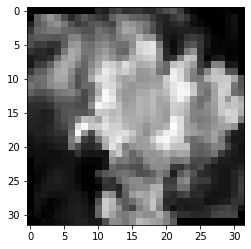

In [ ]:
img, label = test_dataset[1]
plt.imshow(img[0], cmap='gray')
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, FlowerModel()))

Label: bellflower , Predicted: rose


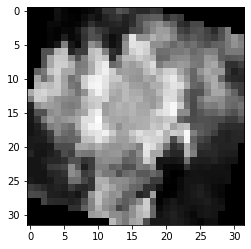

In [ ]:
img, label = test_dataset[1]
plt.imshow(img[0], cmap='gray')
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, FlowerModel()))

# Highest accuracy models loss graph 
Experiment 7

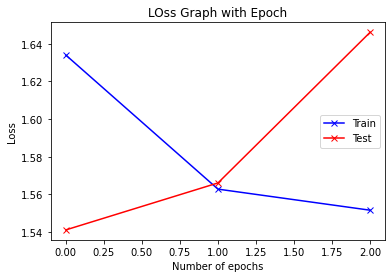

In [ ]:
loss_graph(try2)

Since our epochs are limited with the 3 our figure has a elbow shape at the epoch 1.

After the 0,1 epochs our tests loss is getting higher and train is getting lower values. 
 
But what exactly this loss graph means:

- The loss plot shows how the model is performing on the test data over the course of training. If the loss is decreasing steadily, it means that the model is learning and improving on the test data. On the other hand, if the loss is not decreasing or is increasing, it might indicate that the model is not learning or is overfitting to the training data.

If the loss on the test data is much higher than the loss on the training data, it might indicate that the model is overfitting to the training data and is not generalizing well to new, unseen data. As seen in the figure this is the case after the 1 epoch. We can get better results for the higher epochs but as I said before I have limited ram and computational power.

# Reading data part

In [ ]:
!pip install -U -q PyDrive
 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

 
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
data_path = 'https://drive.google.com/file/d/1WhgxU1C_vSZee0zRy05gGD4OFpdzWYUY/view?usp=sharing'
  
# to get the id part of the file
id = data_path.split("/")[-2]
 
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('flowers.zip')  

In [ ]:
! unzip flowers.zip -d archive

In [ ]:
#Path of test and train

In [ ]:
ROOT_PATH = '/content/archive'
training_path = '/content/archive/flowers/train'
test_path = '/content/archive/flowers/test'


**Checking the device**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

**For normalizing the dataset with Pytorch transforms**

Same for whole project

In [ ]:
mean = [0.554, 0.450, 0.343]
std = [0.231, 0.241, 0.241] 

# Functions for the models

In [ ]:
class ImageClassification(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)
        #out gives the shape of the images                  
        loss = F.cross_entropy(out, labels) 
        # loss is selected as cross_entropy
        return loss
    
    def test_step(self, batch):
        images, labels = batch 
        out = self(images)     
        #out gives the shape of the images 
        loss = F.cross_entropy(out, labels)
        # loss is selected as cross_entropy
        acc = accuracy(out, labels)
        # for accuracy from the accuracy function defined above
        return {'test_loss': loss.detach(), 'test_acc': acc}
        
    def test_epoch_end(self, outputs):
        batch_losses = [x['test_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['test_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item()}
    
    def printer(self, epoch, result):
        print("Finished epoch ----- {}, Loss for Train: {:.2f}, Loss for Test: {:.2f}, ACCURACY: {:.2f}".format(
            epoch, result['train_loss'], result['test_loss'], result['test_acc']*100))

In [ ]:
''' 
Function for the CNN models.

'''
#@torch.no_grad() 

def cnn_ev(model, test_dataloader):
    model.eval()
    outputs = [model.test_step(batch) for batch in test_dataloader]
    return model.test_epoch_end(outputs)

def fit_cnn(epochs, lr, model, train_dataloader, test_dataloader, optim=torch.optim.Adam): #easy to change the lr, epoch and optimizer
    history = []
    optimizer = optim(model.parameters(), lr)
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for batch in train_dataloader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Results for test
        result = cnn_ev(model, test_dataloader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.printer(epoch, result)
        history.append(result)
    
    return history

In [ ]:
#Function for plotting the loss of model with epochs
def loss_graph(try1):
    train_losses = [x.get('train_loss') for x in try1]
    test_losses = [x['test_loss'] for x in try1]
    plt.plot(train_losses, '-bx')
    plt.plot(test_losses, '-rx')
    plt.xlabel('Number of epochs')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Test'])
    plt.title('LOss Graph with Epoch');

In [ ]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [ ]:
#Training functioon for MLP with device for selecting cpu
def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for (x, y) in tqdm(iterator, desc="Training", leave=False):
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_pred, _ = model(x)
        loss = criterion(y_pred, y)
        acc = calculate_accuracy(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):
            x = x.to(device)
            y = y.to(device)
            y_pred, _ = model(x)
            loss = criterion(y_pred, y)
            acc = calculate_accuracy(y_pred, y)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return flower_type[preds[0].item()]

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# Multi Layer NN with Image size 64x64x1 & Batch size 64 lr=0.1 Epoch=3 Activation = relu Hidden Layer=100 neuron

## Preparing the data

In [ ]:
image_size = 64  # 32x32, 64x64, 128x128
batch_size = 64

main_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # 32x32
    transforms.ToTensor(),
    transforms.Normalize(mean,std)      # normalize
])

aug_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomRotation(20),   # rotate images 20 degree randomly
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1,0.1,0.1),    # about saturation brightness vs.
    transforms.ToTensor(),
    transforms.Normalize(mean,std),
    transforms.Grayscale(num_output_channels=1)
    #transforms.RandomErasing()      #randomly erasing pixels 
])
train_dataset = datasets.ImageFolder(training_path, transform=aug_transform)
test_dataset = datasets.ImageFolder(test_path, transform=aug_transform)
flower_type = {0: 'bellflower',1: 'daisy',2: 'dandelion',3: 'lotus',4: 'rose',5: 'sunflower',6: 'tulip'}

print(train_dataset.classes)
print(len(train_dataset), len(test_dataset))
print()

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=2)
#shuffle our training set as it will be used for stochastic gradient descent
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, num_workers=2)

['bellflower', 'daisy', 'dandelion', 'lotus', 'rose', 'sunflower', 'tulip']
9800 1400



64


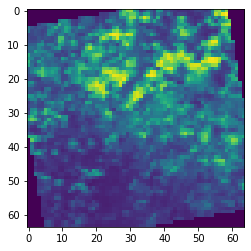

In [ ]:
images, labels = next(iter(train_dataloader))
#Showing a image for how it looks like
print(len(images[1,0]))
plt.imshow(images[0,0])

## Example For Images

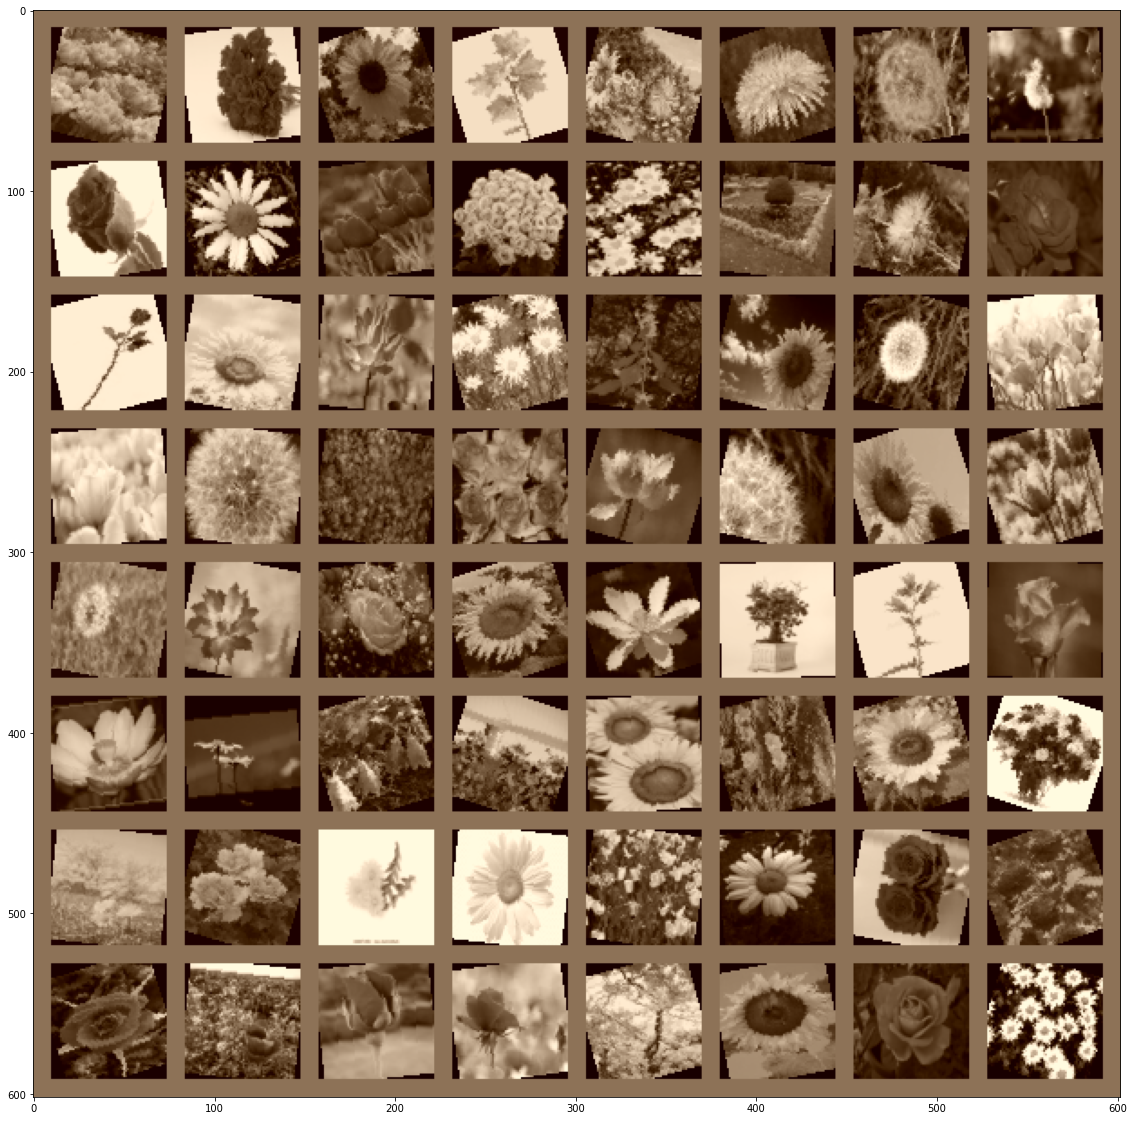

In [ ]:
images, targets = next(iter(train_dataloader))
grid_images = torchvision.utils.make_grid(images, nrow=8, padding=10)

def imshow(images, mean, std):
        np_image = np.array(images).transpose((1,2,0))
        unnorm_image = np_image * std + mean
        plt.figure(figsize=(20,20))
        plt.imshow(unnorm_image)
        
imshow(grid_images, mean, std)

## Model

In [ ]:
INPUT_DIM = 64 * 64
OUTPUT_DIM = 7
EPOCHS = 3


class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, 250)
        self.hidden_fc = nn.Linear(250, 100)
        self.output_fc = nn.Linear(100, output_dim)

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        h_1 = F.relu(self.input_fc(x))
        h_2 = F.relu(self.hidden_fc(h_1))
        y_pred = self.output_fc(h_2)
        return y_pred, h_2

model = MLP(INPUT_DIM, OUTPUT_DIM)
#As loss function,  will use sum of negative log-likelihood of the correct labels.



In [ ]:
import torch.optim as optim


In [ ]:
optimizer = optim.Adam(model.parameters(),lr=0.1)
criterion = nn.CrossEntropyLoss()  #negative log likelihood.
model = model.to(device)
criterion = criterion.to(device)

In [ ]:

best_valid_loss = float('inf')

for epoch in trange(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_dataloader, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, test_dataloader, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Test. Loss: {valid_loss:.3f} |  Test. Acc: {valid_acc*100:.2f}%')

  0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/154 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 1m 22s
	Train Loss: 60.625 | Train Acc: 13.96%
	 Test. Loss: 2.011 |  Test. Acc: 14.28%


Training:   0%|          | 0/154 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 1m 33s
	Train Loss: 2.009 | Train Acc: 13.66%
	 Test. Loss: 1.962 |  Test. Acc: 14.77%


Training:   0%|          | 0/154 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 1m 24s
	Train Loss: 1.970 | Train Acc: 14.15%
	 Test. Loss: 1.948 |  Test. Acc: 14.20%


# Multi Layer NN with Image size 32x32x1 & Batch size 64 lr=0.01 Epoch=3 Activation = relu HiddenLayer= 50 neuron

## Preparing the data

In [ ]:
image_size = 32  # 32x32, 64x64, 128x128
batch_size = 64

main_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # 32x32
    transforms.ToTensor(),
    transforms.Normalize(mean,std)      # normalize
])

aug_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomRotation(20),   # rotate images 20 degree randomly
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1,0.1,0.1),    # about saturation brightness vs.
    transforms.ToTensor(),
    transforms.Normalize(mean,std),
    transforms.Grayscale(num_output_channels=1)
    #transforms.RandomErasing()      #randomly erasing pixels 
])
train_dataset = datasets.ImageFolder(training_path, transform=aug_transform)
test_dataset = datasets.ImageFolder(test_path, transform=aug_transform)
flower_type = {0: 'bellflower',1: 'daisy',2: 'dandelion',3: 'lotus',4: 'rose',5: 'sunflower',6: 'tulip'}

print(train_dataset.classes)
print(len(train_dataset), len(test_dataset))
print()

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=2)
#shuffle our training set as it will be used for stochastic gradient descent
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, num_workers=2)

['bellflower', 'daisy', 'dandelion', 'lotus', 'rose', 'sunflower', 'tulip']
9800 1400



32


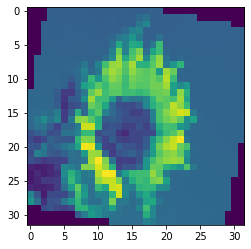

In [ ]:
images, labels = next(iter(train_dataloader))
#Showing a image for how it looks like
print(len(images[1,0]))
plt.imshow(images[0,0])

## Example For Images

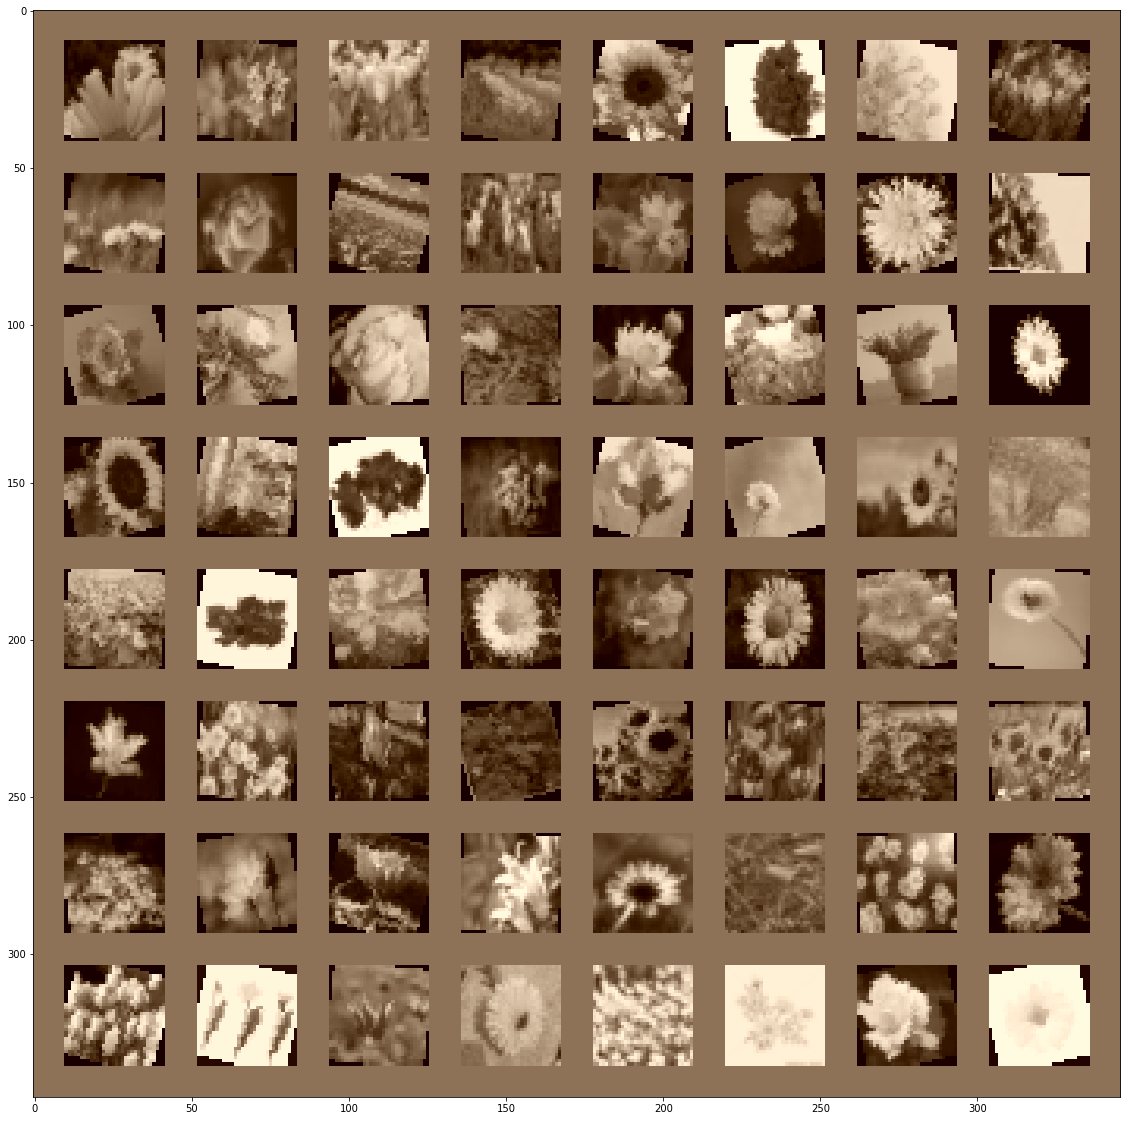

In [ ]:
images, targets = next(iter(train_dataloader))
grid_images = torchvision.utils.make_grid(images, nrow=8, padding=10)

def imshow(images, mean, std):
        np_image = np.array(images).transpose((1,2,0))
        unnorm_image = np_image * std + mean
        plt.figure(figsize=(20,20))
        plt.imshow(unnorm_image)
        
imshow(grid_images, mean, std)

## Model

In [ ]:
INPUT_DIM = 32 * 32
OUTPUT_DIM = 7
EPOCHS = 3


class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, 250)
        self.hidden_fc = nn.Linear(250, 50)
        self.output_fc = nn.Linear(50, output_dim)

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        h_1 = F.relu(self.input_fc(x))
        h_2 = F.relu(self.hidden_fc(h_1))
        y_pred = self.output_fc(h_2)
        return y_pred, h_2

model = MLP(INPUT_DIM, OUTPUT_DIM)
#As loss function,  will use sum of negative log-likelihood of the correct labels.

In [ ]:
optimizer = optim.Adam(model.parameters(),lr=0.01)
criterion = nn.CrossEntropyLoss()  #negative log likelihood.
model = model.to(device)
criterion = criterion.to(device)

In [ ]:

best_valid_loss = float('inf')

for epoch in trange(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_dataloader, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, test_dataloader, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Test. Loss: {valid_loss:.3f} |  Test. Acc: {valid_acc*100:.2f}%')



  0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/154 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 1m 19s
	Train Loss: 1.932 | Train Acc: 20.43%
	 Test. Loss: 1.842 |  Test. Acc: 25.80%


Training:   0%|          | 0/154 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 1m 26s
	Train Loss: 1.836 | Train Acc: 24.07%
	 Test. Loss: 1.817 |  Test. Acc: 24.90%


Training:   0%|          | 0/154 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 1m 16s
	Train Loss: 1.819 | Train Acc: 25.03%
	 Test. Loss: 1.811 |  Test. Acc: 25.13%


# Multi Layer NN with Image size 32x32x1 & Batch size 32 lr=0.001 Epoch=3 Activation=relu 2 Hidden Layers


## Preparing the data

In [ ]:
image_size = 32  # 32x32, 64x64, 128x128
batch_size = 32

main_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # 32x32
    transforms.ToTensor(),
    transforms.Normalize(mean,std)      # normalize
])

aug_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomRotation(20),   # rotate images 20 degree randomly
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1,0.1,0.1),    # about saturation brightness vs.
    transforms.ToTensor(),
    transforms.Normalize(mean,std),
    transforms.Grayscale(num_output_channels=1)
    #transforms.RandomErasing()      #randomly erasing pixels 
])
train_dataset = datasets.ImageFolder(training_path, transform=aug_transform)
test_dataset = datasets.ImageFolder(test_path, transform=aug_transform)
flower_type = {0: 'bellflower',1: 'daisy',2: 'dandelion',3: 'lotus',4: 'rose',5: 'sunflower',6: 'tulip'}

print(train_dataset.classes)
print(len(train_dataset), len(test_dataset))
print()

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=2)
#shuffle our training set as it will be used for stochastic gradient descent
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, num_workers=2)

['bellflower', 'daisy', 'dandelion', 'lotus', 'rose', 'sunflower', 'tulip']
9800 1400



32


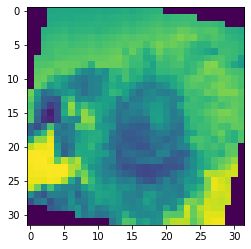

In [ ]:
images, labels = next(iter(train_dataloader))
#Showing a image for how it looks like
print(len(images[1,0]))
plt.imshow(images[0,0])

## Example For Images

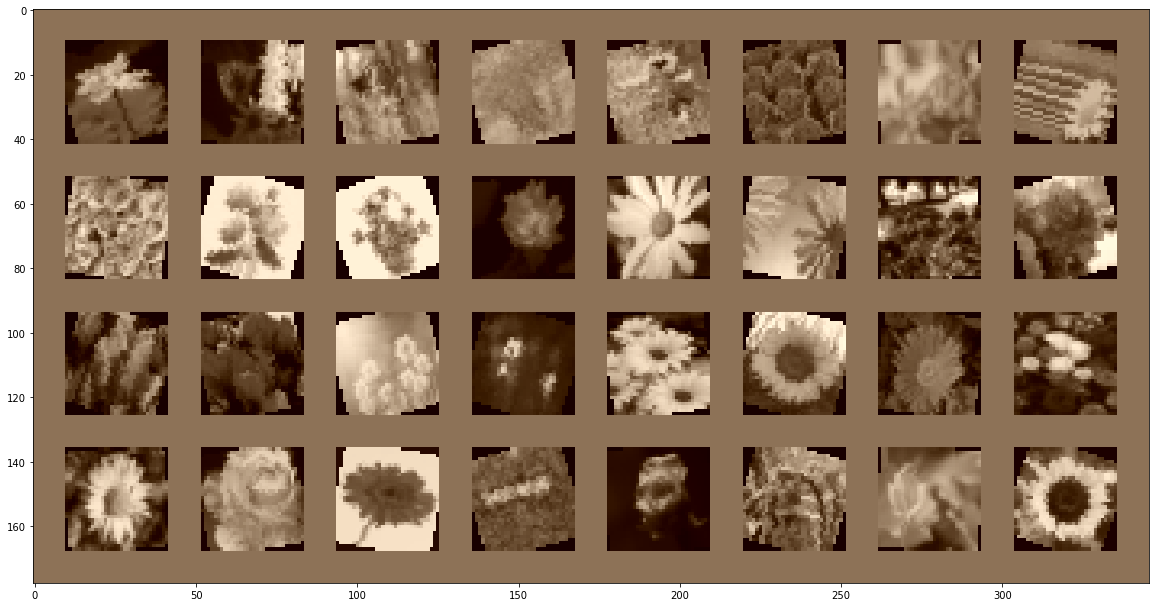

In [ ]:
images, targets = next(iter(train_dataloader))
grid_images = torchvision.utils.make_grid(images, nrow=8, padding=10)

def imshow(images, mean, std):
        np_image = np.array(images).transpose((1,2,0))
        unnorm_image = np_image * std + mean
        plt.figure(figsize=(20,20))
        plt.imshow(unnorm_image)
        
imshow(grid_images, mean, std)

## Model

In [ ]:
INPUT_DIM = 32 * 32
OUTPUT_DIM = 7
EPOCHS = 3


class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, 250)
        self.hidden_fc1 = nn.Linear(250, 200)
        self.hidden_fc2 = nn.Linear(200, 100)
        self.output_fc = nn.Linear(100, output_dim)

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        h_1 = F.relu(self.input_fc(x))
        h_2 = F.relu(self.hidden_fc1(h_1))
        h_3 = F.relu(self.hidden_fc2(h_2))
        y_pred = self.output_fc(h_3)
        return y_pred, h_3

model = MLP(INPUT_DIM, OUTPUT_DIM)
#As loss function,  will use sum of negative log-likelihood of the correct labels.



In [ ]:
optimizer = optim.Adam(model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()  #negative log likelihood.
model = model.to(device)
criterion = criterion.to(device)

In [ ]:

best_valid_loss = float('inf')

for epoch in trange(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_dataloader, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, test_dataloader, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Test. Loss: {valid_loss:.3f} |  Test. Acc: {valid_acc*100:.2f}%')


  0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/307 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 1m 17s
	Train Loss: 1.783 | Train Acc: 28.26%
	 Test. Loss: 1.746 |  Test. Acc: 30.35%


Training:   0%|          | 0/307 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 1m 18s
	Train Loss: 1.718 | Train Acc: 31.92%
	 Test. Loss: 1.745 |  Test. Acc: 31.18%


Training:   0%|          | 0/307 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 1m 17s
	Train Loss: 1.693 | Train Acc: 33.13%
	 Test. Loss: 1.741 |  Test. Acc: 30.54%


# Multi Layer NN with Image size 32x32x1 & Batch size 16 lr= 0.001 Epoch=3 Activation = sigmoid

## Preparing the data

In [ ]:
image_size = 32  # 32x32, 64x64, 128x128
batch_size = 16

main_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # 32x32
    transforms.ToTensor(),
    transforms.Normalize(mean,std)      # normalize
])

aug_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomRotation(20),   # rotate images 20 degree randomly
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1,0.1,0.1),    # about saturation brightness vs.
    transforms.ToTensor(),
    transforms.Normalize(mean,std),
    transforms.Grayscale(num_output_channels=1)
    #transforms.RandomErasing()      #randomly erasing pixels 
])
train_dataset = datasets.ImageFolder(training_path, transform=aug_transform)
test_dataset = datasets.ImageFolder(test_path, transform=aug_transform)
flower_type = {0: 'bellflower',1: 'daisy',2: 'dandelion',3: 'lotus',4: 'rose',5: 'sunflower',6: 'tulip'}

print(train_dataset.classes)
print(len(train_dataset), len(test_dataset))
print()

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=2)
#shuffle our training set as it will be used for stochastic gradient descent
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, num_workers=2)

['bellflower', 'daisy', 'dandelion', 'lotus', 'rose', 'sunflower', 'tulip']
9800 1400



32


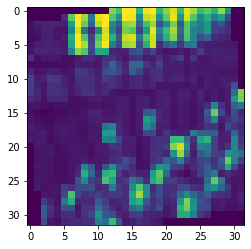

In [ ]:
images, labels = next(iter(train_dataloader))
#Showing a image for how it looks like
print(len(images[1,0]))
plt.imshow(images[0,0])

## Example For Images

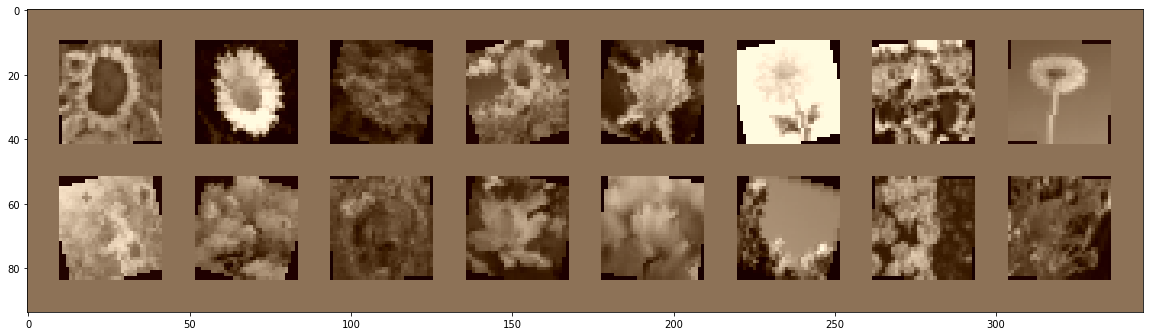

In [ ]:
images, targets = next(iter(train_dataloader))
grid_images = torchvision.utils.make_grid(images, nrow=8, padding=10)

def imshow(images, mean, std):
        np_image = np.array(images).transpose((1,2,0))
        unnorm_image = np_image * std + mean
        plt.figure(figsize=(20,20))
        plt.imshow(unnorm_image)
        
imshow(grid_images, mean, std)

## Model

In [ ]:
INPUT_DIM = 32 * 32
OUTPUT_DIM = 7
EPOCHS = 3

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.input_fc = nn.Linear(input_dim, 250)
        self.hidden_fc = nn.Linear(250, 100)
        self.output_fc = nn.Linear(100, output_dim)

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        h_1 = F.sigmoid(self.input_fc(x))
        h_2 = F.sigmoid(self.hidden_fc(h_1))
        y_pred = self.output_fc(h_2)
        return y_pred, h_2

model = MLP(INPUT_DIM, OUTPUT_DIM)
#As loss function,  will use sum of negative log-likelihood of the correct labels.



In [ ]:
optimizer = optim.Adam(model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()  #negative log likelihood.
model = model.to(device)
criterion = criterion.to(device)

In [ ]:


best_valid_loss = float('inf')

for epoch in trange(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_dataloader, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, test_dataloader, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Test. Loss: {valid_loss:.3f} |  Test. Acc: {valid_acc*100:.2f}%')



  0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/613 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Evaluating:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 2m 5s
	Train Loss: 1.807 | Train Acc: 27.26%
	 Test. Loss: 1.757 |  Test. Acc: 30.68%


Training:   0%|          | 0/613 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 1m 41s
	Train Loss: 1.741 | Train Acc: 31.36%
	 Test. Loss: 1.748 |  Test. Acc: 32.03%


Training:   0%|          | 0/613 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 1m 35s
	Train Loss: 1.718 | Train Acc: 32.13%
	 Test. Loss: 1.753 |  Test. Acc: 29.97%


# Multi Layer NN with Image size 32x32x1 & Batch size 16 lr= 0.001 Epoch=10

## Preparing the data

In [ ]:
image_size = 32  # 32x32, 64x64, 128x128
batch_size = 16

main_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # 32x32
    transforms.ToTensor(),
    transforms.Normalize(mean,std)      # normalize
])

aug_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomRotation(20),   # rotate images 20 degree randomly
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1,0.1,0.1),    # about saturation brightness vs.
    transforms.ToTensor(),
    transforms.Normalize(mean,std),
    transforms.Grayscale(num_output_channels=1)
    #transforms.RandomErasing()      #randomly erasing pixels 
])
train_dataset = datasets.ImageFolder(training_path, transform=aug_transform)
test_dataset = datasets.ImageFolder(test_path, transform=aug_transform)
flower_type = {0: 'bellflower',1: 'daisy',2: 'dandelion',3: 'lotus',4: 'rose',5: 'sunflower',6: 'tulip'}

print(train_dataset.classes)
print(len(train_dataset), len(test_dataset))
print()

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=2)
#shuffle our training set as it will be used for stochastic gradient descent
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, num_workers=2)

['bellflower', 'daisy', 'dandelion', 'lotus', 'rose', 'sunflower', 'tulip']
9800 1400



32


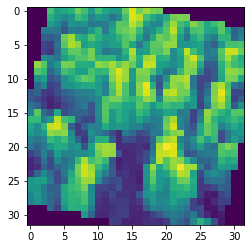

In [ ]:
images, labels = next(iter(train_dataloader))
#Showing a image for how it looks like
print(len(images[1,0]))
plt.imshow(images[0,0])

## Example For Images

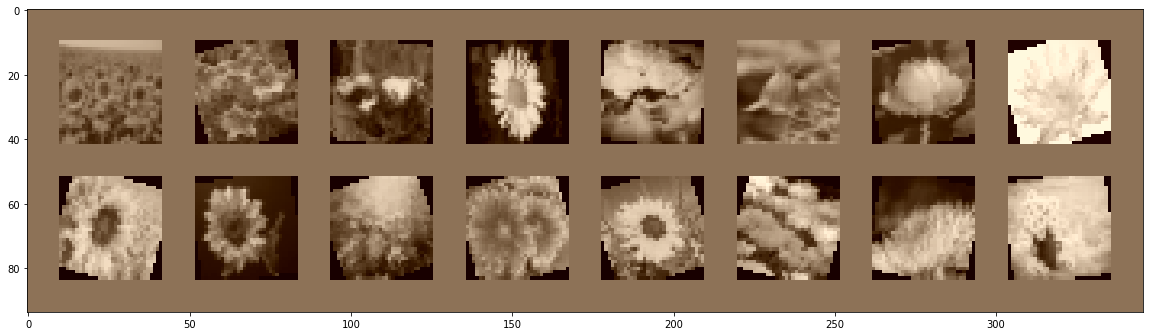

In [ ]:
images, targets = next(iter(train_dataloader))
grid_images = torchvision.utils.make_grid(images, nrow=8, padding=10)

def imshow(images, mean, std):
        np_image = np.array(images).transpose((1,2,0))
        unnorm_image = np_image * std + mean
        plt.figure(figsize=(20,20))
        plt.imshow(unnorm_image)
        
imshow(grid_images, mean, std)

## Model

In [ ]:
INPUT_DIM = 32 * 32
OUTPUT_DIM = 7
EPOCHS = 10

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, 250)
        self.hidden_fc = nn.Linear(250, 100)
        self.output_fc = nn.Linear(100, output_dim)

    def forward(self, x):

    
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        h_1 = F.relu(self.input_fc(x))
        h_2 = F.relu(self.hidden_fc(h_1))
        y_pred = self.output_fc(h_2)
        return y_pred, h_2

model = MLP(INPUT_DIM, OUTPUT_DIM)
#As loss function,  will use sum of negative log-likelihood of the correct labels.



In [ ]:
optimizer = optim.Adam(model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()  #negative log likelihood.
model = model.to(device)
criterion = criterion.to(device)

In [ ]:


best_valid_loss = float('inf')

for epoch in trange(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_dataloader, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, test_dataloader, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Test. Loss: {valid_loss:.3f} |  Test. Acc: {valid_acc*100:.2f}%')



  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/613 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 1m 22s
	Train Loss: 1.783 | Train Acc: 28.20%
	 Test. Loss: 1.755 |  Test. Acc: 29.97%


Training:   0%|          | 0/613 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 1m 19s
	Train Loss: 1.727 | Train Acc: 31.34%
	 Test. Loss: 1.720 |  Test. Acc: 32.10%


Training:   0%|          | 0/613 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 1m 21s
	Train Loss: 1.702 | Train Acc: 32.62%
	 Test. Loss: 1.717 |  Test. Acc: 33.24%


Training:   0%|          | 0/613 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 1m 20s
	Train Loss: 1.683 | Train Acc: 33.31%
	 Test. Loss: 1.706 |  Test. Acc: 32.81%


Training:   0%|          | 0/613 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 1m 22s
	Train Loss: 1.668 | Train Acc: 34.33%
	 Test. Loss: 1.720 |  Test. Acc: 31.46%


Training:   0%|          | 0/613 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 1m 21s
	Train Loss: 1.646 | Train Acc: 35.34%
	 Test. Loss: 1.698 |  Test. Acc: 33.52%


Training:   0%|          | 0/613 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 1m 26s
	Train Loss: 1.633 | Train Acc: 35.91%
	 Test. Loss: 1.694 |  Test. Acc: 32.53%


Training:   0%|          | 0/613 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 1m 20s
	Train Loss: 1.617 | Train Acc: 36.99%
	 Test. Loss: 1.704 |  Test. Acc: 33.81%


Training:   0%|          | 0/613 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 1m 22s
	Train Loss: 1.608 | Train Acc: 38.10%
	 Test. Loss: 1.692 |  Test. Acc: 35.51%


Training:   0%|          | 0/613 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 1m 21s
	Train Loss: 1.597 | Train Acc: 37.92%
	 Test. Loss: 1.729 |  Test. Acc: 31.89%


# CNN with Image Size 64x64x3 with Batch size 64 lr=0.1 Epoch=3

## Preaparing the data

In [ ]:
image_size = 64  # 32x32, 64x64, 128x128
batch_size = 64

main_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # 32x32
    transforms.ToTensor(),
    transforms.Normalize(mean,std)      # normalize
])

aug_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomRotation(20),   # rotate images 20 degree randomly
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1,0.1,0.1),    # about saturation brightness vs.
    transforms.ToTensor(),
    transforms.Normalize(mean,std),
    #transforms.Grayscale(num_output_channels=1)
    #transforms.RandomErasing()      #randomly erasing pixels 
])
train_dataset = datasets.ImageFolder(training_path, transform=aug_transform)
test_dataset = datasets.ImageFolder(test_path, transform=aug_transform)
flower_type = {0: 'bellflower',1: 'daisy',2: 'dandelion',3: 'lotus',4: 'rose',5: 'sunflower',6: 'tulip'}

print(train_dataset.classes)
print(len(train_dataset), len(test_dataset))
print()

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=2)
#shuffle our training set as it will be used for stochastic gradient descent
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, num_workers=2)

['bellflower', 'daisy', 'dandelion', 'lotus', 'rose', 'sunflower', 'tulip']
9800 1400



## Example for Images

64


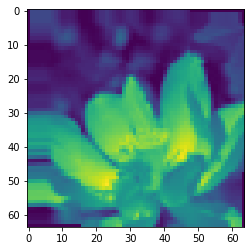

In [ ]:
images, labels = next(iter(train_dataloader))

print(len(images[0,2]))
plt.imshow(images[0,0])

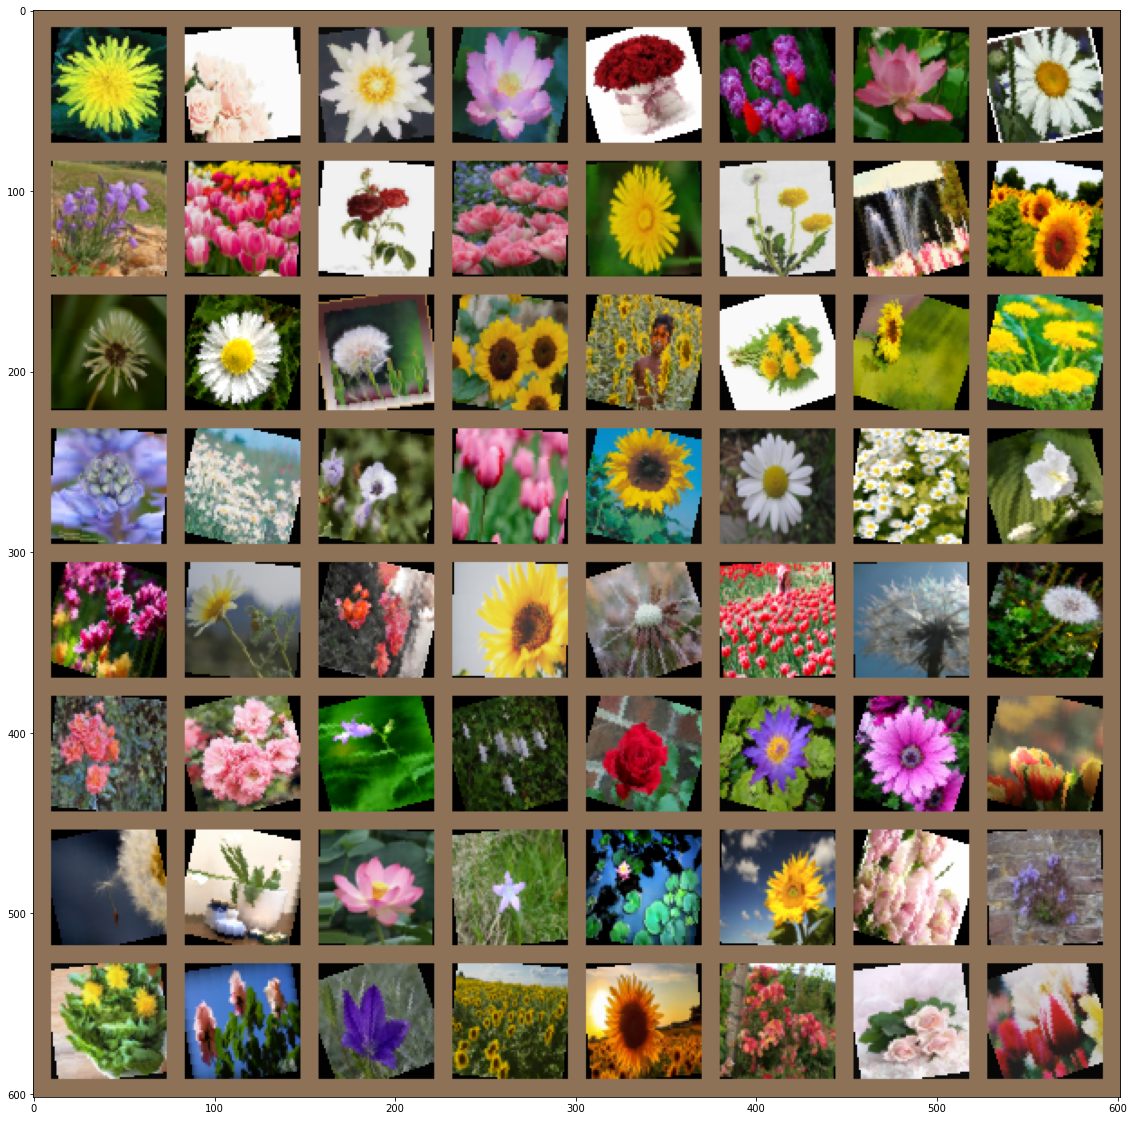

In [ ]:
images, targets = next(iter(train_dataloader))
grid_images = torchvision.utils.make_grid(images, nrow=8, padding=10)

def imshow(images, mean, std):
        np_image = np.array(images).transpose((1,2,0))
        unnorm_image = np_image * std + mean
        plt.figure(figsize=(20,20))
        plt.imshow(unnorm_image)
        
imshow(grid_images, mean, std)

## Model


In [ ]:
epochs = 3
optim = torch.optim.Adam
lr = 0.1
class FlowerModel(ImageClassification):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32*64*64, 7)

    def forward(self, xb):
        xb = self.conv1(xb)
        xb = F.relu(xb)
        xb = xb.view(-1, 32*64*64)
        xb = self.fc1(xb)
        return xb

model = FlowerModel()
model

FlowerModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=131072, out_features=7, bias=True)
)

In [ ]:
for images, labels in train_dataloader:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

cnn_ev(model, test_dataloader)

In [ ]:
%%time
try1 = fit_cnn(epochs, lr, model, train_dataloader, test_dataloader, optim)

Finished epoch ----- 0, Loss for Train: 745.58, Loss for Test: 1.99, ACCURACY: 15.25
Finished epoch ----- 1, Loss for Train: 1.96, Loss for Test: 1.93, ACCURACY: 15.66
Finished epoch ----- 2, Loss for Train: 1.95, Loss for Test: 1.94, ACCURACY: 19.21
CPU times: user 1min, sys: 4.66 s, total: 1min 5s
Wall time: 4min 24s


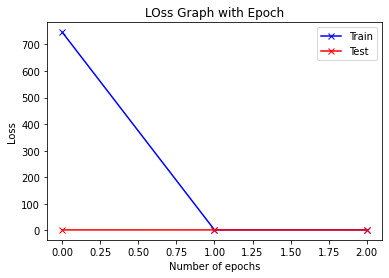

In [ ]:
loss_graph(try1)

## Misclassified Images

Label: bellflower , Predicted: sunflower


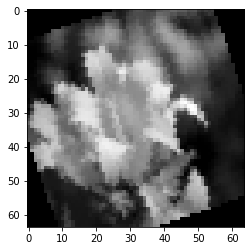

In [ ]:
img, label = test_dataset[1]
plt.imshow(img[0], cmap='gray')
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, FlowerModel()))

# CNN with Image Size 32x32x3 & Batch size 16 lr=0.001 Epoch=3 2 CONV 2FC Activation=sigmoid

## Preaparing the data

In [ ]:
image_size = 32  # 32x32, 64x64, 128x128
batch_size = 16

main_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # 32x32
    transforms.ToTensor(),
    transforms.Normalize(mean,std)      # normalize
])

aug_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomRotation(20),   # rotate images 20 degree randomly
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1,0.1,0.1),    # about saturation brightness vs.
    transforms.ToTensor(),
    transforms.Normalize(mean,std),
    #transforms.Grayscale(num_output_channels=1)
    #transforms.RandomErasing()      #randomly erasing pixels 
])
train_dataset = datasets.ImageFolder(training_path, transform=aug_transform)
test_dataset = datasets.ImageFolder(test_path, transform=aug_transform)
flower_type = {0: 'bellflower',1: 'daisy',2: 'dandelion',3: 'lotus',4: 'rose',5: 'sunflower',6: 'tulip'}

print(train_dataset.classes)
print(len(train_dataset), len(test_dataset))
print()

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=2)
#shuffle our training set as it will be used for stochastic gradient descent
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, num_workers=2)

['bellflower', 'daisy', 'dandelion', 'lotus', 'rose', 'sunflower', 'tulip']
9800 1400



## Example for Images

32


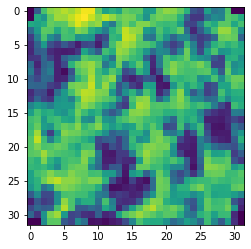

In [ ]:
images, labels = next(iter(train_dataloader))

print(len(images[0,2]))
plt.imshow(images[0,0])

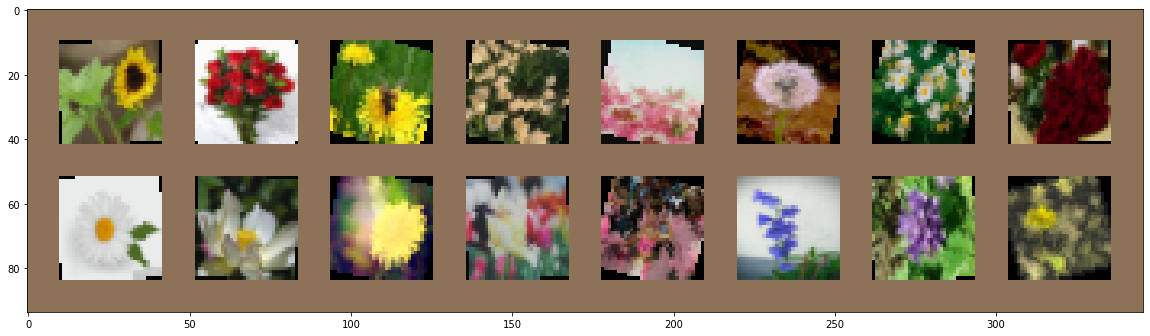

In [ ]:
images, targets = next(iter(train_dataloader))
grid_images = torchvision.utils.make_grid(images, nrow=8, padding=10)

def imshow(images, mean, std):
        np_image = np.array(images).transpose((1,2,0))
        unnorm_image = np_image * std + mean
        plt.figure(figsize=(20,20))
        plt.imshow(unnorm_image)
        
imshow(grid_images, mean, std)

## Model


In [ ]:
epochs = 3
optim = torch.optim.Adam
lr = 0.001
class FlowerModel(ImageClassification):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64*32*32, 128)
        self.fc2 = nn.Linear(128, 7)

    def forward(self, xb):
        xb = self.conv1(xb)
        xb = F.relu(xb)
        xb = self.conv2(xb)
        xb = F.relu(xb)
        xb = xb.view(-1, 64*32*32)
        xb = self.fc1(xb)
        xb = F.relu(xb)
        xb = self.fc2(xb)
        return F.sigmoid(xb)

model = FlowerModel()
model

FlowerModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=65536, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=7, bias=True)
)

In [ ]:
for images, labels in train_dataloader:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

cnn_ev(model, test_dataloader)

images.shape: torch.Size([16, 3, 32, 32])
out.shape: torch.Size([16, 7])
out[0]: tensor([0.5126, 0.5106, 0.5139, 0.4935, 0.5106, 0.4963, 0.4829],
       grad_fn=<SelectBackward0>)


{'test_loss': 1.9471888542175293, 'test_acc': 0.13991476595401764}

In [ ]:
%%time
try2 = fit_cnn(epochs, lr, model, train_dataloader, test_dataloader, optim)

Finished epoch ----- 0, Loss for Train: 1.63, Loss for Test: 1.54, ACCURACY: 51.78
Finished epoch ----- 1, Loss for Train: 1.56, Loss for Test: 1.57, ACCURACY: 52.13
Finished epoch ----- 2, Loss for Train: 1.55, Loss for Test: 1.65, ACCURACY: 42.97
CPU times: user 7min 38s, sys: 11.2 s, total: 7min 49s
Wall time: 8min 45s


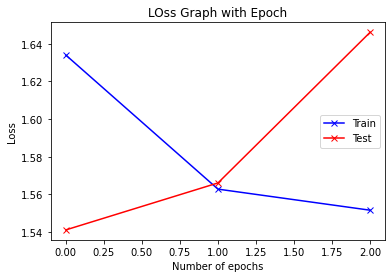

In [ ]:
loss_graph(try2)

## Misclassified Images

Label: bellflower , Predicted: tulip


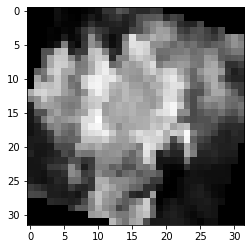

In [ ]:
img, label = test_dataset[1]
plt.imshow(img[0], cmap='gray')
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, FlowerModel()))

# CNN with Image Size 32x32x3 & Batch size 16 lr=0.1 Epoch=3 2 CONV 2FC Activation=sigmoid different layer size

## Preaparing the data

In [ ]:
image_size = 32  # 32x32, 64x64, 128x128
batch_size = 16

main_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # 32x32
    transforms.ToTensor(),
    transforms.Normalize(mean,std)      # normalize
])

aug_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomRotation(20),   # rotate images 20 degree randomly
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1,0.1,0.1),    # about saturation brightness vs.
    transforms.ToTensor(),
    transforms.Normalize(mean,std),
    #transforms.Grayscale(num_output_channels=1)
    #transforms.RandomErasing()      #randomly erasing pixels 
])
train_dataset = datasets.ImageFolder(training_path, transform=aug_transform)
test_dataset = datasets.ImageFolder(test_path, transform=aug_transform)
flower_type = {0: 'bellflower',1: 'daisy',2: 'dandelion',3: 'lotus',4: 'rose',5: 'sunflower',6: 'tulip'}

print(train_dataset.classes)
print(len(train_dataset), len(test_dataset))
print()

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=2)
#shuffle our training set as it will be used for stochastic gradient descent
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, num_workers=2)

['bellflower', 'daisy', 'dandelion', 'lotus', 'rose', 'sunflower', 'tulip']
9800 1400



## Example for Images

32


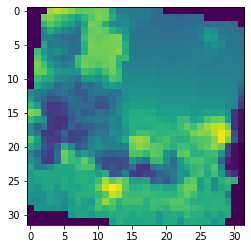

In [ ]:
images, labels = next(iter(train_dataloader))

print(len(images[0,2]))
plt.imshow(images[0,0])

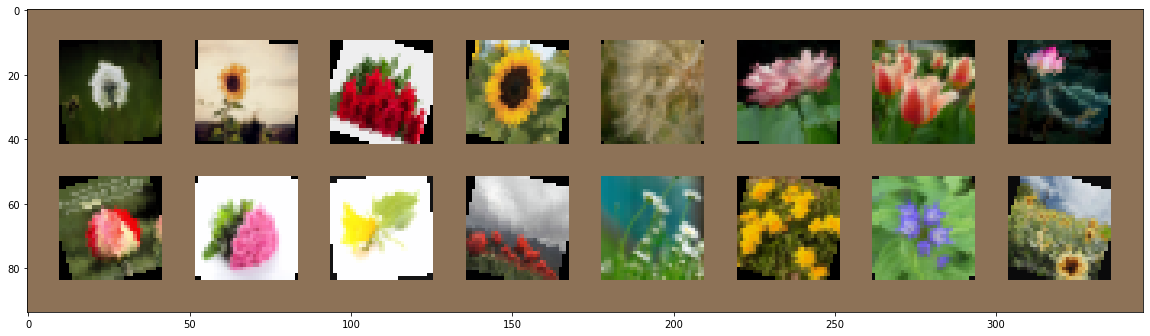

In [ ]:
images, targets = next(iter(train_dataloader))
grid_images = torchvision.utils.make_grid(images, nrow=8, padding=10)

def imshow(images, mean, std):
        np_image = np.array(images).transpose((1,2,0))
        unnorm_image = np_image * std + mean
        plt.figure(figsize=(20,20))
        plt.imshow(unnorm_image)
        
imshow(grid_images, mean, std)

## Model


In [ ]:
epochs = 3
optim = torch.optim.Adam
lr = 0.1
class FlowerModel(ImageClassification):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32*32*32, 64)
        self.fc2 = nn.Linear(64, 7)

    def forward(self, xb):
        xb = self.conv1(xb)
        xb = F.relu(xb)
        xb = self.conv2(xb)
        xb = F.relu(xb)
        xb = xb.view(-1, 32*32*32)
        xb = self.fc1(xb)
        xb = F.relu(xb)
        xb = self.fc2(xb)
        return F.sigmoid(xb)


model = FlowerModel()
model

FlowerModel(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=32768, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=7, bias=True)
)

In [ ]:
for images, labels in train_dataloader:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

cnn_ev(model, test_dataloader)

In [ ]:
%%time
try3 = fit_cnn(epochs, lr, model, train_dataloader, test_dataloader, optim)

Finished epoch ----- 0, Loss for Train: 2.07, Loss for Test: 2.07, ACCURACY: 14.20
Finished epoch ----- 1, Loss for Train: 2.07, Loss for Test: 2.07, ACCURACY: 14.20
Finished epoch ----- 2, Loss for Train: 2.07, Loss for Test: 2.07, ACCURACY: 14.20
CPU times: user 2min 25s, sys: 4.53 s, total: 2min 29s
Wall time: 4min 56s


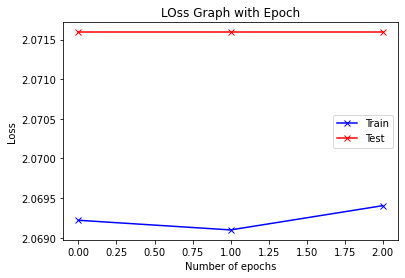

In [ ]:
loss_graph(try3)

## Misclassified Images

Label: bellflower , Predicted: daisy


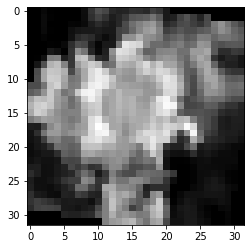

In [ ]:
img, label = test_dataset[1]
plt.imshow(img[0], cmap='gray')
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, FlowerModel()))